In [57]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import IPython
import cv2

In [58]:
#Read the CSV file and display head/shape of the dataset
#4541 rows of data describing each pose(frame) of the left side camera
#12 values detailing the position of the camera wrt origin position
poses = pd.read_csv('Data Set/data_odometry_poses/dataset/poses/00.txt',delimiter=' ', header=None)
print ('Shape of position of dataframe:',poses.shape)
poses.head()


Shape of position of dataframe: (4541, 12)


,0,1,2,3,4,5,6,7,8,9,10,11
0,1.000000,9.043680e-12,2.326809e-11,5.551115e-17,9.043683e-12,1.000000,2.392370e-10,3.330669e-16,2.326810e-11,2.392370e-10,1.000000,-4.440892e-16
1,0.999998,5.272628e-04,-2.066935e-03,-4.690294e-02,-5.296506e-04,0.999999,-1.154865e-03,-2.839928e-02,2.066324e-03,1.155958e-03,0.999997,8.586941e-01
2,0.999991,1.048972e-03,-4.131348e-03,-9.374345e-02,-1.058514e-03,0.999997,-2.308104e-03,-5.676064e-02,4.128913e-03,2.312456e-03,0.999989,1.716275e+00
3,0.999980,1.566466e-03,-6.198571e-03,-1.406429e-01,-1.587952e-03,0.999993,-3.462706e-03,-8.515762e-02,6.193102e-03,3.472479e-03,0.999975,2.574964e+00
4,0.999964,2.078471e-03,-8.263498e-03,-1.874858e-01,-2.116664e-03,0.999987,-4.615826e-03,-1.135202e-01,8.253797e-03,4.633149e-03,0.999955,3.432648e+00


In [59]:
#Converting the 12 values to 3x4 transformation matrix
#Print the first position, i.e the first row of the data set which signifies the initial pose of the camera 
#Reshape it to 3x4 matrix (3x3 rotation matrix with 3x1 translation vector in the R/t form)
#Print the first position of the camera
#Change the value of iloc[n] to obtain camera values at nth instance
print("First Position:")
first_pose=np.array(poses.iloc[0]).reshape((3,4)).round(2)
first_pose

First Position:


array([[ 1.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  0.,  1., -0.]])

In [60]:
#Creating an array of ground truth poses for all 4541 data entries
#Initialize with zero for better memory access and reduced error
ground_truth_poses=np.zeros((len(poses),3,4))
for i in range (len(poses)):
    ground_truth_poses[i]=np.array(poses.iloc[i]).reshape((3,4)).round(2)

In [61]:
#dot product of camera position with origin to get the movement
ground_truth_poses[1].dot(np.array([0,0,0,1]))

array([-0.05, -0.03,  0.86])

In [62]:
#use ipyml instead of notebook because dependencies do not support notebook. double check to update ipympl.
%matplotlib ipympl

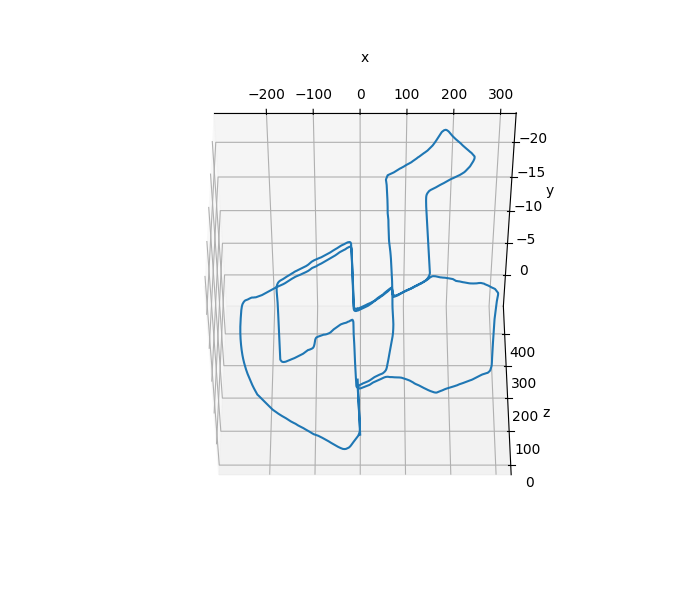

In [63]:
fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(ground_truth_poses[:, :, 3][:, 0], ground_truth_poses[:, :, 3][:, 1], ground_truth_poses[:, :, 3][:, 2])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(elev=-40, azim=270)

In [64]:
# For reference, display the first image in the dataset, i.e initial camera pose (ground_truth_pose[0])
%matplotlib inline
initial_image = cv2.imread("D:/Code/Python Projects/Visual Odometry/Data Set/data_odometry_color/dataset/sequences/00/image_2/000000.png")
# plt.imshow(initial_image)
# plt.show()
#OpenCV uses BGR as default color channel. Convert it to RGB for accurate color representation otherwise it will appear distorted.
initial_image_rgb = cv2.cvtColor(initial_image, cv2.COLOR_BGR2RGB)

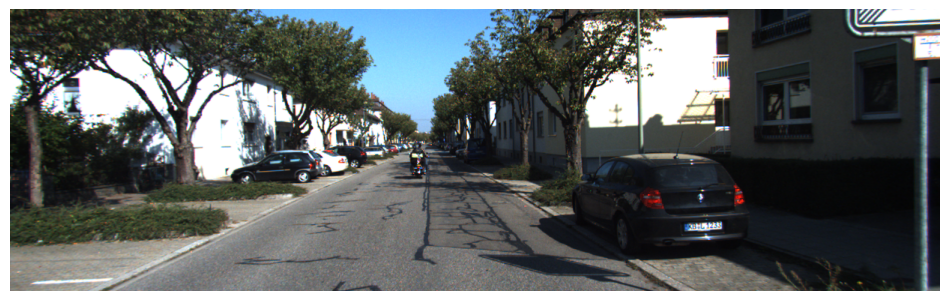

In [66]:
#Creating a new state (figure) is important because matplotlib retains state and will try to reproduce the image using the earlier plot
plt.figure(figsize=(12, 6)) 
plt.imshow(initial_image_rgb)
plt.axis('off')  # Turn off axis labels
plt.show()

In [67]:
#Load the corrected sensor calibration data 
#P0-P3 are RECTIFIED projection matrices. They are translated from each individual camera system.. 
#.. to the system of the left camera, as opposed to global coordinate frame to each individual camera. 
calib = pd.read_csv('D:/Code/Python Projects/Visual Odometry/Data Set/data_odometry_calib/dataset/sequences/00/calib.txt',delimiter=' ', header=None)
calib

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,P0:,718.856000,0.000000,607.192800,0.000000,0.000000,718.856000,185.215700,0.000000,0.000000,0.000000,1.000000,0.000000
1,P1:,718.856000,0.000000,607.192800,-386.144800,0.000000,718.856000,185.215700,0.000000,0.000000,0.000000,1.000000,0.000000
2,P2:,718.856000,0.000000,607.192800,45.382250,0.000000,718.856000,185.215700,-0.113089,0.000000,0.000000,1.000000,0.003780
3,P3:,718.856000,0.000000,607.192800,-337.287700,0.000000,718.856000,185.215700,2.369057,0.000000,0.000000,1.000000,0.004915
4,Tr:,0.000428,-0.999967,-0.008084,-0.011985,-0.007211,0.008081,-0.999941,-0.054040,0.999974,0.000486,-0.007207,-0.292197


In [76]:
#Printing the projection matrix of the leftside Grayscale camera. 
#This matrix contains intrinsic information about the focal length and optical center of the leftside camera.
P0 = np.array(calib.loc[0,1:]).reshape((3,4))
P0

array([[718.856, 0.0, 607.1928, 0.0],
       [0.0, 718.856, 185.2157, 0.0],
       [0.0, 0.0, 1.0, 0.0]], dtype=object)

In [87]:
# Decomposing a projection matrix with OpenCV
#OpenCV uses cv.Mat or cv.UMat format to decompose matrix and not numpy array
#We first convert it to UMat format to decompose. Then convert it back to np array to index through and get the values.
P1 = np.array(calib.loc[1,1:]).reshape((3,4))
P1_cv = cv2.UMat(P1.astype('float32'))
k1, r1, t1, _, _, _, _ = cv2.decomposeProjectionMatrix(P1_cv)
t1_np = np.array(t1.get()).reshape(-1)
t1_np = t1_np / t1_np[3]
k1_np = np.array(k1.get())
r1_np = np.array(r1.get())
print('Intrinsic Matrix:')
print(k1_np)
print('Rotation Matrix:')
print(r1_np)
print('Translation Vector:')
print(t1_np.round(4))

Intrinsic Matrix:
[[718.856    0.     607.1928]
 [  0.     718.856  185.2157]
 [  0.       0.       1.    ]]
Rotation Matrix:
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Translation Vector:
[0.5372 0.     0.     1.    ]
